In [78]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

#Y_tau = sigma * torch.randn(64,64)
#print(Y_tau)

def gauss_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size):
    Y_tau = Y_0
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau / sigma / sigma) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, H):
    Y_tau = Y_0
    c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
    cov = np.zeros((image_size, image_size))
    for i in range(image_size):
        for j in range(image_size):
            cov[i][j] = c[abs(i - j)]
    inv_cov = np.linalg.inv(cov) 
    inv_covariance = torch.Tensor(inv_cov)
    for i in range(langevin_step_num):
        noise = torch.randn(image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (2 * inv_covariance * Y_tau / sigma / sigma) + langevin_step_size * noise
    return Y_tau


def gauss_omega_mcmc_simulate_omega(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
    Y_tau = Y_0
    omegat = range(image_size) 
    omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
    #print(omega)
    beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
    #print(beta_omega)
    for i in range(langevin_step_num):
        Y_tau = Variable(Y_tau, requires_grad=True)
        noise = torch.randn(image_size)
        #print(Y_tau.size())
        Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
        #print(Y_ftau.size())
        Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
        #print(Y_aftau.size())
        #print(i)
        log_pY = -0.5 * Y_aftau.dot(beta_omega)
        log_pY.backward()
        #print(i, Y_tau, noise, Y_tau.grad)
        Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau.grad) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau.data.numpy()
#def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
#    Y_tau = Y_0
#    omegat = range(image_size * image_size) 
#    omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
#    #beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
#    beta_omega = [xx ** beta / image_size / image_size for xx in omega]
#    beta_omega = torch.from_numpy(beta_omega)
#    print(beta_omega)
#    for i in range(langevin_step_num):
#        noise = torch.randn(image_size, image_size)
#        Y_ftau = torch.rfft(Y_tau ,2 ,onesided=False)
#        Y_aftau = torch.sqrt(Y_ftau[:,:,0]*Y_ftau[:,:,0]+Y_ftau[:,:,1]*Y_ftau[:,:,1])
#        #print(Y_aftau.shape)
#        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
#        (sum(beta_omega) * Y_tau / sigma / sigma) + langevin_step_size * noise
#        print(Y_tau)
#    return Y_tau

#image_size = 128
#Y_0 = sigma * torch.randn(image_size,image_size)
#Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
#out = torch.rfft(Y_u0,2,onesided=False)
#oo = torch.sqrt(out[:,:,0]*out[:,:,0]+out[:,:,1]*out[:,:,1])
#print(oo.shape)
#print(Y_u0)
#print(oo)

(array([7.51191112e+01, 5.02655236e+01, 5.74175143e-01, 2.36194416e-01,
        3.64521153e-01, 8.28312248e-02, 6.10053376e-02, 3.64569383e-02,
        7.06654426e-02, 8.64797750e-02, 2.93754714e-02, 2.22483717e-02,
        1.38861369e-01, 5.54814583e-02, 3.96680157e-02, 5.67844251e-02,
        4.09267677e-02, 6.48495134e-02, 1.49989272e-02, 1.82960646e-02,
        5.54344258e-02, 3.42964596e-02, 3.96444740e-02, 1.74219739e-02,
        1.64547330e-02, 1.61585149e-02, 4.30119200e-03, 5.62289695e-03,
        1.54901070e-02, 7.01365617e-03, 4.04361887e-02, 3.63904861e-02,
        9.87428363e-03, 6.26505965e-03, 1.76385134e-04, 5.60417941e-03,
        1.83213453e-02, 1.30015533e-02, 5.20048880e-02, 7.13881961e-02,
        2.73060393e-02, 2.18910104e-03, 6.23605505e-03, 2.63023239e-02,
        1.61700196e-02, 1.43606554e-03, 1.30367185e-03, 2.36480798e-02,
        2.69195582e-02, 1.13196709e-02, 1.31007967e-02, 4.82779580e-03,
        1.50933616e-02, 4.16291065e-03, 8.75213423e-03, 4.707980

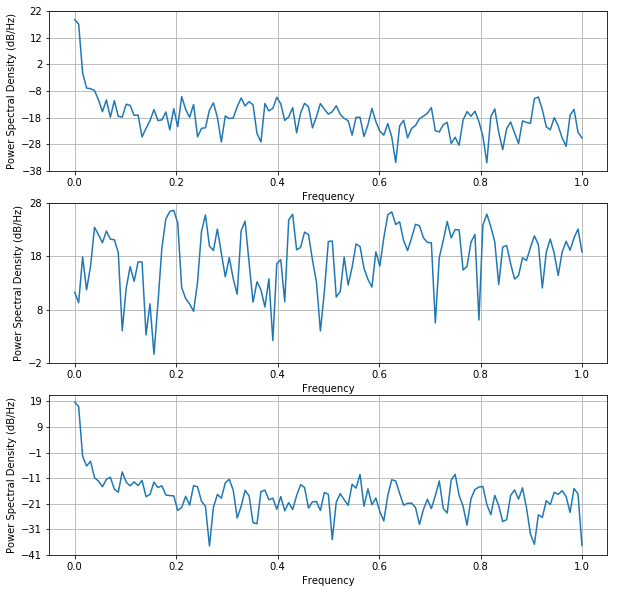

In [80]:
import pylab as plt
langevin_step_size = 0.01
sigma = 10 
langevin_step_num = 200
H = 0.9
beta = 0.1
image_size = 200
Y_0 = sigma * torch.randn(image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size)
Y_u = 0.1 * sigma * torch.ones(image_size)


Y_out = gauss_omega_mcmc_simulate(Y_u ,langevin_step_size ,langevin_step_num ,sigma, image_size, H)
Y_out1 = gauss_omega_mcmc_simulate_omega(Y_u ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta)
#print(Y_out)


plt.figure(figsize=(10,10))
plt.subplot(311)
plt.psd(Y_out)
#plt.subplot(212)
plt.subplot(312)
plt.psd(Y_0)
plt.subplot(313)
plt.psd(Y_out1)

(array([2.37256371e-07, 4.62144758e-07, 4.26877767e-07, 3.73830432e-07,
        3.10328815e-07, 2.44426672e-07, 1.83389806e-07, 1.32500771e-07,
        9.44299115e-08, 6.92498604e-08, 5.49969281e-08, 4.85554762e-08,
        4.65925111e-08, 4.63039354e-08, 4.58296102e-08, 4.43137535e-08,
        4.16904686e-08, 3.83328422e-08, 3.47085097e-08, 3.11443971e-08,
        2.77407389e-08, 2.44146383e-08, 2.10154009e-08, 1.74451640e-08,
        1.37347434e-08, 1.00541767e-08, 6.66641947e-09, 3.85096872e-09,
        1.82818156e-09, 7.07310006e-10, 4.68009767e-10, 9.72812012e-10,
        2.00090431e-09, 3.29228827e-09, 4.59396251e-09, 5.70315446e-09,
        6.50440457e-09, 6.99682437e-09, 7.30617093e-09, 7.67550015e-09,
        8.42985075e-09, 9.91528795e-09, 1.24197897e-08, 1.60907246e-08,
        2.08683829e-08, 2.64549506e-08, 3.23325004e-08, 3.78327878e-08,
        4.22483788e-08, 4.49625486e-08, 4.55682997e-08, 4.39475055e-08,
        4.02902344e-08, 3.50497255e-08, 2.88459237e-08, 2.234446

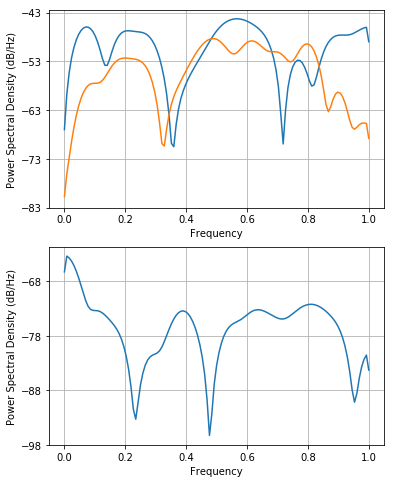

In [3]:
import pylab as plt
langevin_step_size = 0.01
sigma = 0.1  
langevin_step_num = 100
image_size = 32
Y_0 = sigma * torch.randn(image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size)


Y_out = gauss_mcmc_simulate(Y_u0 ,langevin_step_size ,langevin_step_num ,sigma, image_size)
#print(Y_out)


plt.figure(figsize=(6,8))
plt.subplot(211)
plt.psd(Y_0)
#plt.subplot(212)
plt.psd(Y_out)
plt.subplot(212)
plt.psd(Y_u0)

In [4]:
import math
image_size =4
omegat = range(image_size * image_size) 
omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
beta = 0.1
beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
print(omega)
print(sum(beta_omega))
print(1/max(beta_omega))

[-1.5707963267948966, -1.3744467859455345, -1.1780972450961724, -0.9817477042468103, -0.7853981633974483, -0.5890486225480862, -0.39269908169872414, -0.19634954084936207, 0.0, 0.19634954084936207, 0.39269908169872414, 0.5890486225480862, 0.7853981633974483, 0.9817477042468103, 1.1780972450961724, 1.3744467859455345]
0.9069024508903286
15.293539001264099


In [2]:
import torch
import numpy as np
image_size = 4
H = 0.5
c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
print(c)
cov = np.zeros((image_size, image_size))
print(cov)
for i in range(image_size):
    for j in range(image_size):
        cov[i][j] = c[abs(i - j)]
print(cov)
inv_cov = np.linalg.inv(cov) 
print(inv_cov)
inv_covariance = torch.from_numpy(inv_cov)
print(inv_covariance)

[2.0, 0.0, 0.0, 0.0]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
tensor([[0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000]], dtype=torch.float64)


In [25]:
import torch
from torch.autograd import Variable
import math

x = Variable(torch.Tensor([2]), requires_grad=True)
y = x + 2
z = y ** 2 + 3
print(z)

z.backward()
print(x.grad)

sigma = 1
image_size = 8

beta = 0.5
omegat = range(image_size) 
print(omegat)
omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
print(omega)
beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
print(beta_omega.size())


Y_tau = Variable(0.1 * sigma * torch.ones(image_size), requires_grad=True)
print(Y_tau)
Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
print(Y_ftau)
Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
print(Y_aftau.size())
log_pY = -0.5 * Y_aftau.dot(beta_omega) 
print(log_pY)
log_pY.backward()
print(Y_tau.grad)
def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
    Y_tau = Variable(Y_0, requires_grad=True)
    omegat = range(image_size) 
    omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
    #print(omega)
    beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
    print(beta_omega)
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
        Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
        log_pY = -0.5 * Y_aftau.dot(beta_omega)
        log_pY.backward()
        #print(Y_aftau.shape)
        Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau.grad) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

#image_size = 128
#Y_0 = sigma * torch.randn(image_size,image_size)
#Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
#out = torch.rfft(Y_u0,2,onesided=False)
#oo = torch.sqrt(out[:,:,0]*out[:,:,0]+out[:,:,1]*out[:,:,1])
#print(oo.shape)
#print(Y_u0)
#print(oo)

tensor([19.], grad_fn=<AddBackward0>)
tensor([8.])
range(0, 8)
[-1.5707963267948966, -1.1780972450961724, -0.7853981633974483, -0.39269908169872414, 0.0, 0.39269908169872414, 0.7853981633974483, 1.1780972450961724]
torch.Size([8])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
       requires_grad=True)
tensor([[0.8000, 0.0000],
        [0.0000, -0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, -0.0000],
        [0.0000, -0.0000],
        [0.0000, 0.0000]], grad_fn=<SqueezeBackward1>)
torch.Size([8])
tensor(-0.0501, grad_fn=<MulBackward0>)
tensor([-0.1253, -0.1253, -0.1253, -0.1253, -0.1253, -0.1253, -0.1253, -0.1253])
